In [142]:
#----------------standard packages------------------
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#----------------caio's packages--------------------
import sys, os #add code folder to sys.path
sys.path.append(os.path.abspath(os.path.join('../../data_processing')))

from cricsheet_read import cricsheet_read #data processing

#-------------------ML packages---------------------
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as xgb
import xgboost as xgb

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc

match_data = pd.read_csv('../../../data/player_data.csv', dtype = {'match_id':str}).set_index('match_id')
results = cricsheet_read()[1].drop('toss_winner', axis = 1)

              precision    recall  f1-score   support

       False       0.66      0.83      0.74       334
        True       0.76      0.56      0.64       320

    accuracy                           0.70       654
   macro avg       0.71      0.69      0.69       654
weighted avg       0.71      0.70      0.69       654

chasing team always wins: roc auc = 0.500
model prediction: roc auc = 0.786


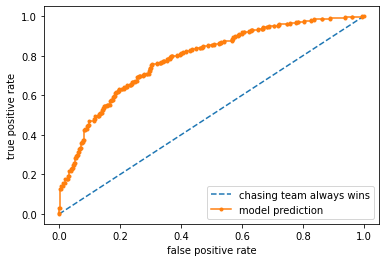

In [166]:
def cric_model(match_data, results, algorithm = 'forest'):
#-----------------preprocessing---------------------
    X = match_data.drop(['set_team_win'], axis = 1).reset_index(drop = True)
    y = match_data['set_team_win']
    non_enconding = ['set_team_toss', 'days_since_match']
    
    encoder = OneHotEncoder()
    X = X[non_enconding].join(pd.DataFrame(encoder.fit_transform(X.drop(non_enconding, axis = 1)).toarray()))
    X.columns = X.columns.map(str)
    
    #sampler = RandomUnderSampler(sampling_strategy = 'majority')
    #X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
    
    #test_data = results[results.index.isin(y_test.index)]
    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

#------------------algorithms-----------------------      
    if algorithm == 'xgb':
        clf = xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
        clf.fit(X_train,y_train)
        xgb.plot_importance(clf,importance_type='weight')
        plt.show()
        print(pd.DataFrame.from_dict(clf.get_booster().get_fscore(),
                             orient = 'index').sort_values(0, ascending = False).head(10))  
    else:
        clf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 1,
                                     max_features = 'auto', max_depth = 100, bootstrap = True)
        clf.fit(X_train, y_train)
    
    test_data['prob_set'] = clf.predict_proba(X_test)[:,1]
    test_data['prob_chase'] = clf.predict_proba(X_test)[:,0]
    y_pred = clf.predict(X_test)

#-------------------metrics-------------------------    
    accuracy = accuracy_score(y_test,y_pred)
    print(classification_report(y_test,y_pred))

    false_auc = roc_auc_score(y_test, y_test.clip(upper = False))
    model_auc = roc_auc_score(y_test, test_data['prob_set'])
    
    print('chasing team always wins: roc auc = %.3f' % (false_auc))
    print('model prediction: roc auc = %.3f' % (model_auc))
    
    false_fpr, false_tpr, _ = roc_curve(y_test, y_test.clip(upper = False))
    model_fpr, model_tpr, _ = roc_curve(y_test, test_data['prob_set'])

    plt.plot(false_fpr, false_tpr, linestyle = '--', label = 'chasing team always wins')
    plt.plot(model_fpr, model_tpr, marker = '.', label = 'model prediction')

    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()

    return test_data, clf, accuracy
#---------------------------------------------------
test_data, clf, accuracy = cric_model(match_data, results, algorithm = 'forest')

In [128]:
test_data

,start_date,league,venue,match_name,set_team_win,prob_set,prob_chase
2612,2020-02-23,Pakistan Super League,Gaddafi Stadium,Lahore Qalandars v Islamabad United,False,0.367208,0.632792
2613,2020-02-26,T20 Internationals,Newlands,South Africa v Australia,True,0.709268,0.290732
2614,2020-02-26,Pakistan Super League,Multan Cricket Stadium,Multan Sultans v Peshawar Zalmi,False,0.198466,0.801534
2615,2020-02-27,Pakistan Super League,Rawalpindi Cricket Stadium,Islamabad United v Quetta Gladiators,False,0.169059,0.830941
2616,2020-02-28,Pakistan Super League,Multan Cricket Stadium,Multan Sultans v Karachi Kings,True,0.493450,0.506550
...,...,...,...,...,...,...,...
3261,2022-01-03,Big Bash League,Melbourne Cricket Ground,Melbourne Stars v Melbourne Renegades,False,0.281038,0.718962
3262,2022-01-04,Big Bash League,Carrara Oval,Perth Scorchers v Sydney Sixers,True,0.408462,0.591538
3263,2022-01-05,Big Bash League,Adelaide Oval,Hobart Hurricanes v Adelaide Strikers,False,0.364362,0.635638
3264,2022-01-06,Big Bash League,Carrara Oval,Perth Scorchers v Sydney Thunder,False,0.317246,0.682754


In [109]:
X, y = match_data.drop(['set_team_win'], axis = 1), match_data['set_team_win']
non_players = ['days_since_match', 'set_team_toss']

encoder = OneHotEncoder()
X = X[non_players].join(pd.DataFrame(encoder.fit_transform(X.drop(non_players, axis = 1)).toarray()))
X.columns = X.columns.map(str)

#sampler = RandomUnderSampler(sampling_strategy = 'majority')
#X, y = sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

test_data = X_test.join(y_test).copy()

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

In [111]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [112]:
def evaluate(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(100 * accuracy))
    
    return accuracy

base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 68.65%.
Model Performance
Accuracy = 70.18%.
Improvement of 2.23%.


In [ ]:
team_h = ['RG Sharma', 'Babar Azam', 'SPD Smith', 'KS Williamson', 'Q de Kock',
          'M Labuschagne', 'JO Holder', 'R Ashwin', 'TA Boult', 'Shaheen Shah Afridi', 'PJ Cummins']

team_c = ['DA Warner', 'V Kohli', 'BA Stokes', 'C de Grandhomme', 'MS Dhoni',
          'JE Root', 'JDS Neesham', 'MA Starc', 'Rashid Khan', 'JJ Bumrah', 'SL Malinga']

team_harsha = ['JC Buttler', 'Mohammad Rizwan', 'MR Marsh', 'MM Ali', 'GJ Maxwell',
               'AD Russell', 'SP Narine', 'Rashid Khan', 'Shaheen Shah Afridi', 'A Nortje', 'JJ Bumrah']

team_boss = ['EJG Morgan']

data = match_data.head(1)
data[data.columns] = 0
data[team_h] = 1
data[team_boss] = 2
data['days_since_match'] = 0
data.drop(['match_id', 'set_team_win'], axis = 1, inplace = True)

clf.predict(data)

print('set_prob',clf.predict_proba(data)[:,1])
print('chase_prob',clf.predict_proba(data)[:,0])
clf.predict(data)
